In [1]:
import numpy as np
import xarray as xr
from useful_functions import data_compiler
from useful_functions import month_genesis_locs
from useful_functions import grid_counter
from useful_functions import environmental_select_stack
from useful_functions import create_genesis_grid_labels
from useful_functions import take_closest_point
from useful_functions import temporal_spatial_smoothing
from distance import distance_calculator
from distance import pointdist_calc
import os
import tropycal.tracks as tracks
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import cartopy.crs as ccrs
import copy
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import mean_squared_error
from scipy import stats
import regionmask
import geopandas as gpd

In [2]:
# Read the shapefile
gdf = gpd.read_file(
    "/glade/work/acheung/Initial_RF_Datasets/shape_files_regions/World_Seas_IHO_v3.shp")

In [3]:
Latitude=np.arange(0,60,2)
Longitude=np.arange(260,360,2)
# Create masks based on regions
NAO_polygon = gdf.loc[(
    gdf['NAME'] == 'North Atlantic Ocean') | (
    gdf['NAME'] == 'Gulf of Mexico') | (
    gdf['NAME'] == 'Caribbean Sea')]
lon_adj = np.where(Longitude > 180, Longitude - 360,Longitude)
NAOmask = regionmask.mask_geopandas(
    NAO_polygon, Longitude, Latitude, lon_name='Longitude', lat_name='Latitude', wrap_lon=True)

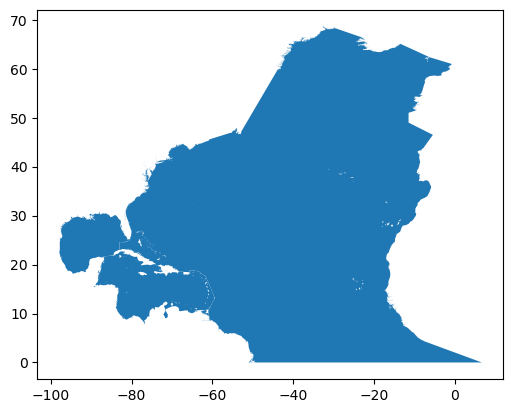

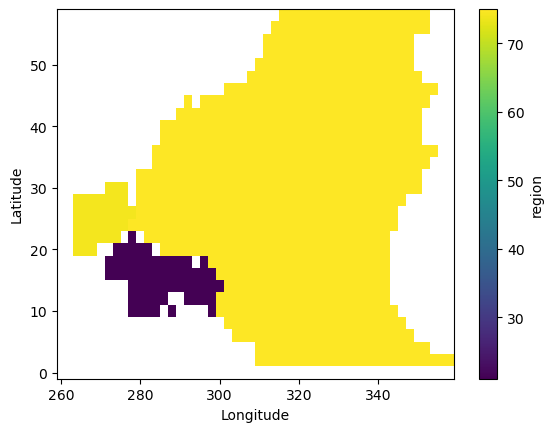

In [4]:
NAO_polygon.plot(); plt.show()
NAOmask.plot(); plt.show()

In [5]:
# Compile Environmental Data
vars_list = os.listdir("/glade/work/acheung/TC_Genesis") # Determine Variables
vars_list.remove('.DS_Store')
vars_list.remove('CRH_ERA5')
all_vars_list = []
for vars_list_now in vars_list:
    Varcompiled, YearList, lons, lats, arr = data_compiler(vars_list_now)
    all_vars_list.append(Varcompiled)

In [6]:
arr = xr.DataArray(all_vars_list,
                   coords=[("Variable",vars_list),
                           ("Year",range(1950,2021)),
                           ("Latitude",lats),
                           ("Longitude",lons),
                           ("Month",range(1,13))])

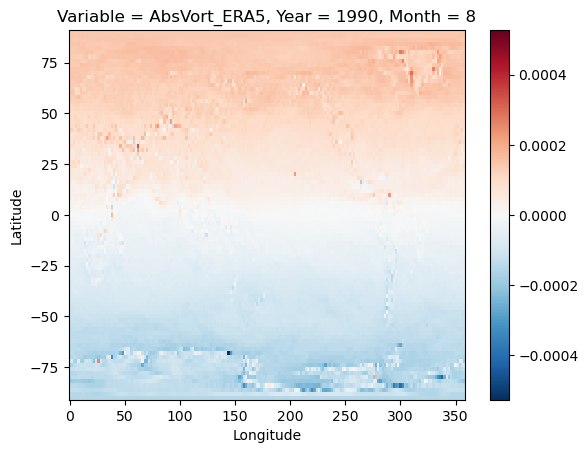

In [7]:
arr.isel(Variable=0,Month=7,Year=40).plot()

In [8]:
# # Time ranges for EVERYTHING desired 
# NOTE: Keep in mind that when switching these values... 
# you may need to adjust create_genesis_grid_labels in useful_functions and also rerun/uncomment the code below!

# Set time parameters
month_range = np.arange(1,13,1)
test_years = np.arange(2005,2021,1)
train_years = np.arange(1950,2005,1)
train_years = np.setdiff1d(train_years, np.arange(1971,1979,1))

# Grab environmental data from functions for the set time parameters
train_stacked, train_NaNlocs = environmental_select_stack(
    month_range, train_years, Latitude, Longitude, arr)
# Apply land/ocean mask to environmental training information
train_stacked = (train_stacked.unstack()).where(
    NAOmask.isnull() == False).stack(z=("Month","Latitude","Longitude","Year"))

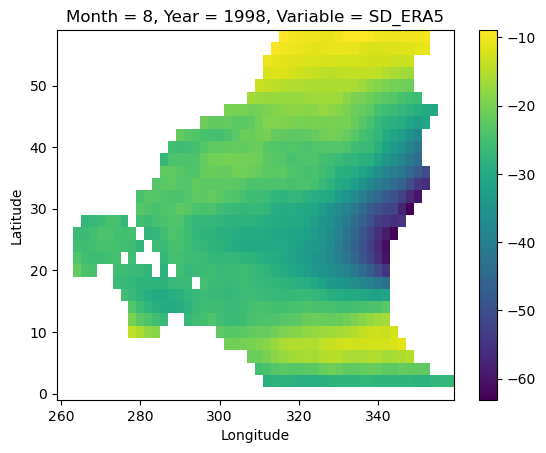

In [9]:
train_stacked.isel(Variable=3).unstack().isel(Month=7,Year=40).plot()

In [10]:
test_stacked, test_NaNlocs = environmental_select_stack(
    month_range, test_years, Latitude, Longitude, arr)

# Apply land/ocean mask to environmental training information
test_stacked = (test_stacked.unstack()).where(
    NAOmask.isnull() == False).stack(
    z=("Month","Latitude","Longitude","Year")) # This is a mask to restrict to only ocean

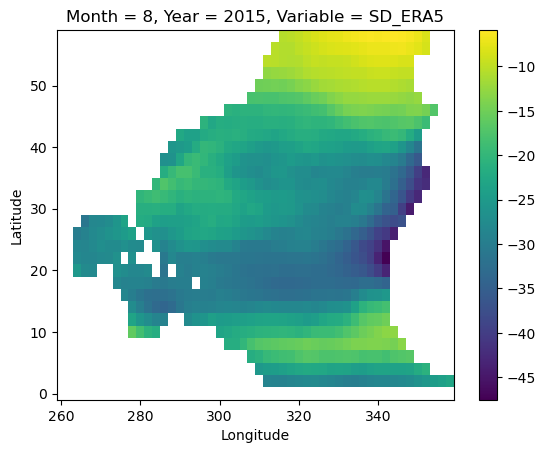

In [11]:
test_stacked.isel(Variable=3).unstack().isel(Month=7,Year=10).plot()

In [12]:
#-------------------------------------------------------------------------------------------------------------------------------------
# Normalize environmental data for training

# Min/Max Scaling (Normalization)
train_stacked_copy   = copy.deepcopy(train_stacked) # For modifying (normalized)
train_stacked_copy_2 = copy.deepcopy(train_stacked) # For referencing 
train_stacked_copy_3 = copy.deepcopy(train_stacked) # For storing anomaly (not normalized)
test_stacked_copy   = copy.deepcopy(test_stacked)
test_stacked_copy_2 = copy.deepcopy(test_stacked)
test_stacked_copy_3 = copy.deepcopy(test_stacked)

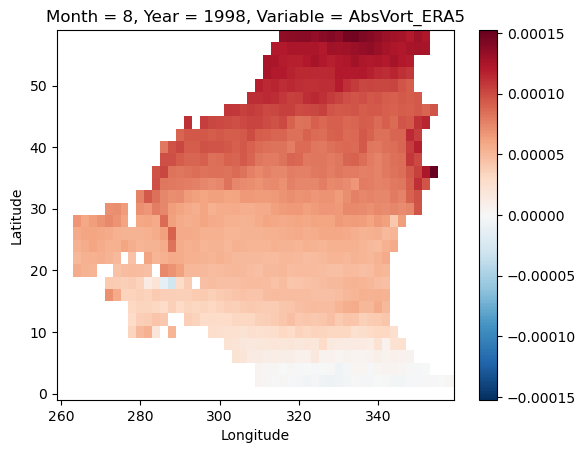

In [13]:
train_stacked_copy_3.isel(Variable=0).unstack().isel(Month=7,Year=40).plot()

In [14]:
# ------------------------------------------Important setting-------------------------------------------------------
anomaly = 1 # 1 = Set for anomaly
# ------------------------------------------------------------------------------------------------------------------

for varloops in range(train_stacked_copy.shape[0]): 
    
    ## Find anomalies and then normalize training Data or not.
    
    if anomaly == 1: # If anomaly desired, this is equal to 1; Base anomalies off training monthly means
    
        # Find Training Data Anomalies
    
        train_monthly_avg = train_stacked_copy_2[varloops].unstack().mean(
            ["Year"]).stack(z=("Month", "Latitude", "Longitude"))
        
        # Calculate Anomaly (subtract values from monthly averages)
        train_anomaly = (
            train_stacked_copy_2[varloops].unstack() - train_monthly_avg.unstack()).stack(
            z=("Month", "Latitude", "Longitude", "Year"))
        
        # Save anomalies before normalization
        train_stacked_copy_3[varloops,:] = train_anomaly
        
        #### Normalize the anomalies and save
        
        #train_stacked_copy[varloops,:] = (
        #    train_anomaly - train_anomaly.min()) / (
        #    train_anomaly.max() - train_anomaly.min())
        
        train_stacked_copy[varloops,:] = (
            train_anomaly - train_anomaly.mean()) / train_anomaly.std()
        
        # Find Testing Data Anomalies (NOTE: Based off training monthly means)
    
        # test_monthly_avg = test_stacked_copy_2[varloops].unstack().mean(["Year"]).stack(z=("Month","Latitude","Longitude"))
        
        # Calculate Anomaly (subtract values from monthly averages)
        test_anomaly = (
            test_stacked_copy_2[varloops].unstack() - train_monthly_avg.unstack()).stack(
            z=("Month", "Latitude", "Longitude", "Year"))
        
        # Save anomalies before normalization
        test_stacked_copy_3[varloops,:] = test_anomaly
        
        #### Normalize the anomalies
        
        #test_stacked_copy[varloops,:] = (
        #    test_anomaly - train_anomaly.min()) / (
        #    train_anomaly.max() - train_anomaly.min())   
        
        test_stacked_copy[varloops,:] = (
            test_anomaly - train_anomaly.mean()) / train_anomaly.std()   
    
    else: # If not predicting anomalies, simply normalization
        
        train_stacked_copy[varloops,:] = (
            train_stacked_copy_2[varloops] - train_stacked_copy_2[varloops].min()) / (
            train_stacked_copy_2[varloops].max() - train_stacked_copy_2[varloops].min())
        
        # Normalize Testing Data Using Training Data Range and Minimum 
        # (KEEP IN MIND testing min/max normalization values use training values)
        test_stacked_copy[varloops,:] = (
            test_stacked_copy_2[varloops] - train_stacked_copy_2[varloops].min()) / (
            train_stacked_copy_2[varloops].max() - train_stacked_copy_2[varloops].min())

In [15]:
# Apply masks and missing data locations
train_env_data = train_stacked_copy.drop_isel(z=train_NaNlocs)#.transpose() # This is locations where there is no data

test_env_data = test_stacked_copy.drop_isel(z=test_NaNlocs)#.transpose()

## This is if we want anomaly, but with no normalization.
# if anomaly == 1:
#     train_env_data_no_norm = train_stacked_copy_3.drop_isel(z=train_NaNlocs).transpose()
#     test_env_data_no_norm = test_stacked_copy_3.drop_isel(z=test_NaNlocs).transpose()

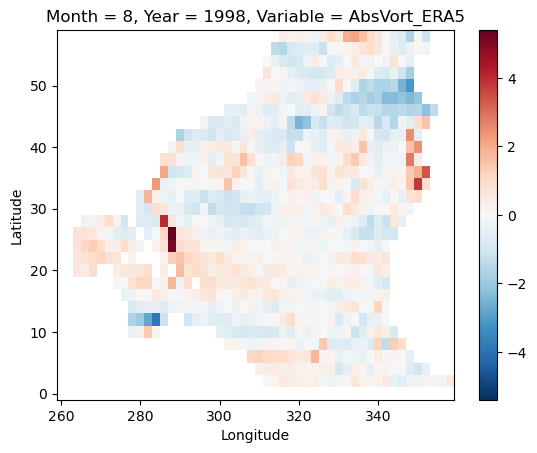

In [16]:
train_env_data.isel(Variable=0).unstack().isel(Month=7,Year=40).plot()

In [17]:
# # Grab ibtracs data (uncomment this section if you want to recreate genesis (observed) labels, otherwise it is already saved)
# basin_dataset = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',include_btk=True)

# # Create genesis labels from ibtracs data (slowest step)
# vmin=0
# print('Training Dataset')
# train_labels_predropped = create_genesis_grid_labels(month_range,train_years,vmin,basin_dataset)
# print('Testing Dataset')
# test_labels_predropped = create_genesis_grid_labels(month_range,test_years,vmin,basin_dataset)

# train_labels_predropped.unstack().to_dataset(name='Genesis_Grids').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
# test_labels_predropped.unstack().to_dataset(name='Genesis_Grids').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")
# # --------------------------------------------------------------------------------------------------------

In [18]:
# Read in already created genesis (obs) labels
train_labels_predropped_read = xr.open_dataset(
    "/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")['Genesis_Grids']
test_labels_predropped_read = xr.open_dataset(
    "/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")['Genesis_Grids']

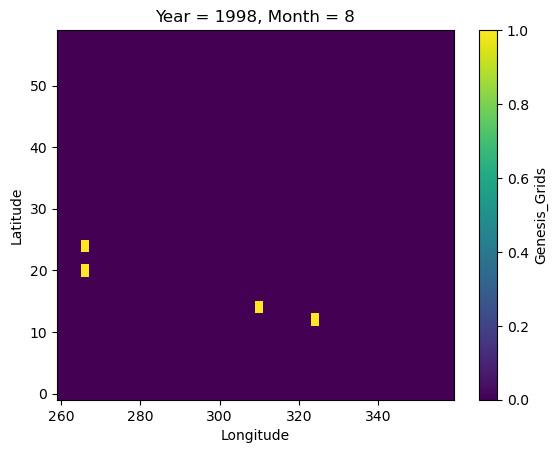

In [19]:
train_labels_predropped_read.isel(Month=7,Year=40).plot()

In [20]:
# Smooth Training Labels
smoothed_training_labels = temporal_spatial_smoothing(
    train_labels_predropped_read.astype(float),0.5,1)

smoothed_training_labels_dropped = smoothed_training_labels.stack(
    z=("Month", "Latitude", "Longitude", "Year")).drop_isel(z=train_NaNlocs)#.transpose()

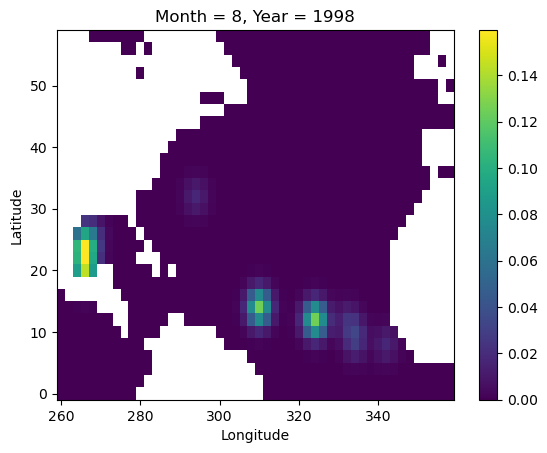

In [21]:
smoothed_training_labels_dropped.unstack().isel(Month=7,Year=40).plot()

In [22]:
# Apply land/ocean mask to training labels
smoothed_training_labels_dropped = smoothed_training_labels_dropped.unstack().where(
    NAOmask.isnull() == False).stack(z=("Month", "Latitude", "Longitude", "Year"))

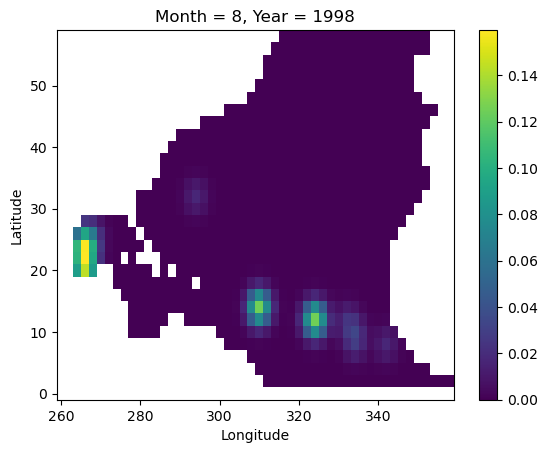

In [23]:
smoothed_training_labels_dropped.unstack().isel(Month=7,Year=40).plot()

In [24]:
# Make training anomaly labels (base climatology off training dataset)
if anomaly == 1:
    
    trainingmonthlymeans = smoothed_training_labels_dropped.unstack().mean('Year')
    
    smoothed_training_labels_dropped = (
        smoothed_training_labels_dropped.unstack() - trainingmonthlymeans).stack(
        z=("Month", "Latitude", "Longitude", "Year"))

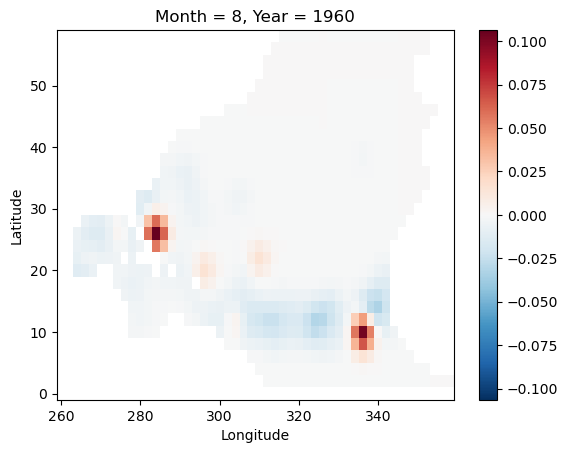

In [25]:
smoothed_training_labels_dropped.unstack().isel(Month=7,Year=10).plot()

In [26]:
#### Normalize Training labels

#smoothed_training_labels_dropped_copy = (
#    smoothed_training_labels_dropped - smoothed_training_labels_dropped.min()) / (
#    smoothed_training_labels_dropped.max() - smoothed_training_labels_dropped.min())

smoothed_training_labels_dropped_copy = (
    smoothed_training_labels_dropped - smoothed_training_labels_dropped.mean()
) / smoothed_training_labels_dropped.std()

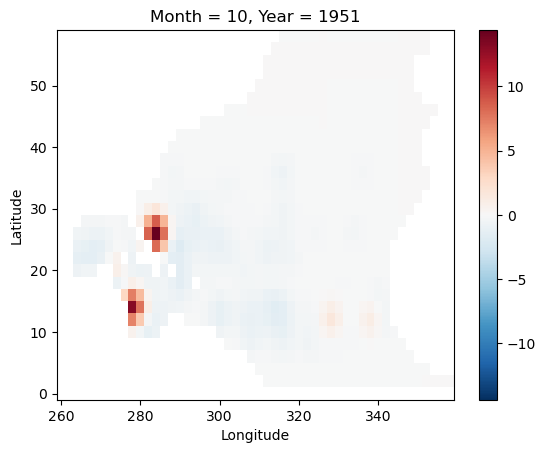

In [27]:
smoothed_training_labels_dropped_copy.unstack().isel(Month=9,Year=1).plot()

In [28]:
#-----------Testing Labels---------------

# Smooth Testing Labels (For verification purposes)
smoothed_testing_labels = temporal_spatial_smoothing(
    test_labels_predropped_read.astype(float), 0.5, 1)

smoothed_testing_labels_dropped = smoothed_testing_labels.stack(
    z=("Month", "Latitude", "Longitude", "Year")).drop_isel(z=test_NaNlocs)#.transpose()

# Apply land/ocean mask to testing labels
smoothed_testing_labels_dropped = smoothed_testing_labels_dropped.unstack().where(
    NAOmask.isnull() == False).stack(z=("Month", "Latitude", "Longitude", "Year"))

# Make testing anomaly labels (base climatology off training dataset)
if anomaly == 1: # Make anomaly labels (base climatology off training dataset)
    smoothed_testing_labels_dropped = (
        smoothed_testing_labels_dropped.unstack() - trainingmonthlymeans).stack(
        z=("Month", "Latitude", "Longitude", "Year"))

#### Normalize Testing labels

#smoothed_testing_labels_dropped = (
#    smoothed_testing_labels_dropped - smoothed_training_labels_dropped.min()) / (
#    smoothed_training_labels_dropped.max() - smoothed_training_labels_dropped.min())

smoothed_testing_labels_dropped = (
    smoothed_testing_labels_dropped - smoothed_training_labels_dropped.mean()
) / smoothed_training_labels_dropped.std()

# Note that above cuts off smoothed labeled values over land, thus changing the sum (may need to revisit)

In [29]:
smoothed_testing_labels_dropped.unstack().shape

(12, 30, 50, 16)

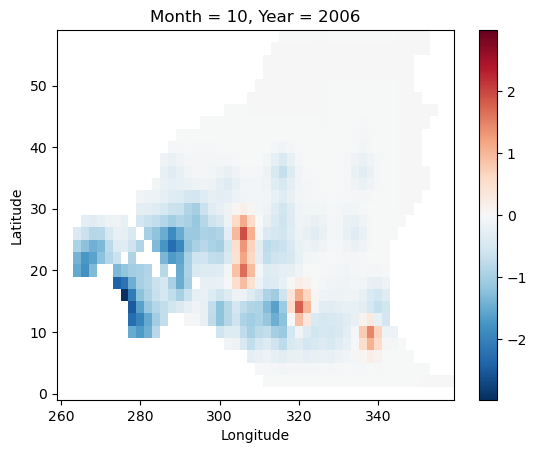

In [30]:
smoothed_testing_labels_dropped.unstack().isel(Month=9,Year=1).plot()

# !!! Uncomment Fit Model Cell if want to fit model !!!

In [419]:
X_training = train_env_data.dropna(dim='z').unstack().isel(Longitude=40,Latitude=12).stack(
    z=("Month", "Year")).transpose('z','Variable')
X_labels = smoothed_training_labels_dropped_copy.dropna(dim='z').unstack().isel(Longitude=40,Latitude=12).stack(
    z=("Month", "Year"))

In [418]:
train_env_data.dropna(dim='z').unstack().isel(Longitude=40,Latitude=12).stack(
    z=("Month", "Year")).transpose('z','Variable')

<xarray.DataArray (z: 564, Variable: 4)>
array([[-0.61255164, -1.79461031,  0.69244537, -0.12578254],
       [ 0.51588593, -0.7026572 ,  0.46181803,  0.50244951],
       [-0.43709348, -1.96906579,  1.26746096, -0.7011451 ],
       ...,
       [-1.76020789,  0.27612853,  2.87357084, -0.90158876],
       [-1.04401466,  1.09554434,  0.19373006,  0.3858879 ],
       [-0.57363367,  0.47374032, -0.33860245, -0.37109476]])
Coordinates:
    Latitude   int16 26
    Longitude  uint16 290
  * Variable   (Variable) <U14 'AbsVort_ERA5' 'VertShear_ERA5' ... 'SD_ERA5'
  * z          (z) object MultiIndex
  * Month      (z) int64 1 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
  * Year       (z) int64 1950 1951 1952 1953 1954 ... 2000 2001 2002 2003 2004

In [576]:
# Fit RF Model
clf = RandomForestRegressor(
    n_estimators=5,
    criterion="friedman_mse",
    max_depth=4,
    min_samples_split=3,
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_features=3,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=10,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=200,
)

In [ ]:
GradientBoostingRegressor()

In [577]:
clf.fit(
    X_training, 
    X_labels
)

RandomForestRegressor(criterion='friedman_mse', max_depth=4, max_features=3,
                      max_samples=200, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=5, random_state=10)

In [578]:
X_testing = test_env_data.dropna(dim='z').unstack().isel(Longitude=40,Latitude=12).stack(
    z=("Month", "Year")).transpose('z','Variable')

In [579]:
# Predict
test_ML_Predict = clf.predict(X_testing)

In [580]:
test_ML_Predict

array([-0.19696692, -0.20930744, -0.56622105, -0.19696692, -0.26803578,
       -0.12734962,  0.04037222, -0.18476811, -0.37693136, -0.26803578,
       -0.37152865,  0.41556275, -0.56622105,  1.03707904, -0.1834752 ,
       -0.22605729,  0.07484213,  0.48909398, -0.45552442, -0.31109357,
        0.98961945, -0.31509191, -0.61393381, -0.53975868, -0.21676475,
       -0.15649184, -0.24193791,  0.43986444, -0.22457377,  0.7718408 ,
       -0.1834752 , -0.56622105,  0.05540561, -0.25236524, -0.08695834,
       -0.41486631, -0.1306596 ,  0.19216474, -0.25236524, -0.15222892,
        0.23839786, -0.15309739,  0.49300557, -0.17004693, -0.19405678,
       -0.22457377,  0.50557424, -0.30032819,  0.467977  , -0.19696692,
       -0.17004693,  0.70608283, -0.054271  ,  0.51067431, -0.1306596 ,
       -0.21676475, -0.32847085, -0.19954963,  0.4244105 , -0.09248538,
        0.55564037, -0.38903408, -0.24193791, -0.25236524, -0.12734962,
       -0.19405678, -0.08154026, -0.25236524, -0.1252103 ,  0.00

In [581]:
y_true = smoothed_testing_labels_dropped.dropna(dim='z').unstack().isel(Longitude=40,Latitude=12).stack(
    z=("Month", "Year"))

In [582]:
y_true

<xarray.DataArray (z: 192)>
array([-4.38957492e-05, -4.38957492e-05, -4.38957492e-05,  5.18623258e-05,
       -4.38957492e-05, -4.38957492e-05, -4.38957492e-05,  5.18431799e-03,
       -4.38957492e-05, -4.38957492e-05, -4.38957492e-05,  3.85262169e-04,
       -4.38957492e-05, -4.38957492e-05, -4.38957492e-05, -4.38957492e-05,
       -1.23617618e-06, -1.23617618e-06, -1.23617618e-06, -9.98815643e-07,
       -1.23617618e-06, -1.23617618e-06, -1.23617618e-06, -1.23617618e-06,
       -1.23617618e-06, -1.23617618e-06, -1.23617618e-06, -1.23617618e-06,
       -1.23617618e-06, -1.23617618e-06, -1.23617618e-06, -1.23617618e-06,
       -5.00726600e-04, -5.00726600e-04, -5.00726600e-04, -5.00726600e-04,
       -5.00726600e-04, -5.00726600e-04, -5.00726600e-04, -5.00061903e-04,
       -5.00726600e-04, -5.00726600e-04, -5.00489239e-04, -4.65499173e-04,
       -5.00726600e-04, -5.00726600e-04,  2.67034533e-03, -5.00726600e-04,
       -4.51304008e-03, -4.51304008e-03, -4.51304008e-03, -4.51304008e-03,
       -4.51304008e-03, -4.51304008e-03, -4.51304008e-03, -4.24488235e-03,
       -4.51304008e-03, -4.51304008e-03, -4.41728201e-03,  9.69871833e-03,
       -4.51304008e-03, -4.51304008e-03,  1.27478868e+00, -4.51304008e-03,
       -1.14149204e-02, -1.14422875e-02, -1.14490841e-02, -1.14501478e-02,
       -1.14501478e-02, -1.14422875e-02, -1.14501478e-02, -9.46871528e-03,
       -1.14501478e-02, -1.14501478e-02, -1.07425860e-02,  9.35613323e-02,
       -1.14501478e-02, -1.13543898e-02,  9.44138311e+00, -1.07425666e-02,
...
        9.82355600e+00, -4.63115057e-01, -2.92722310e-01, -4.39683829e-01,
        8.98654607e+00, -4.62684835e-01, -2.87215692e-01, -4.65856971e-01,
       -4.66286129e-01, -4.42847040e-01,  1.64302159e+00,  1.64292583e+00,
        8.98654607e+00, -4.27654564e-01, -1.66194414e-01, -1.80827470e-01,
        5.90288072e+00, -1.28618665e+00, -6.89172651e-03, -1.11263069e+00,
       -6.89279029e-03, -1.11262283e+00, -1.25673175e+00, -1.11305985e+00,
       -1.28619451e+00, -1.27985237e+00,  1.43000277e+01, -1.00074371e+00,
       -6.89279029e-03, -1.28609876e+00, -1.14255040e+00, -1.28548693e+00,
       -7.09083507e-01, -1.51162939e+00, -1.33849449e+00, -1.48819709e+00,
       -1.50845831e+00, -2.29156591e-01,  5.97642648e-01, -2.32327663e-01,
       -1.51162939e+00, -1.48819030e+00,  7.70812995e-01, -1.51092182e+00,
       -1.50845831e+00, -1.51162939e+00, -1.49732187e+00, -1.51162939e+00,
       -3.11933553e-01, -3.13914985e-01, -3.13390069e-01, -3.13856905e-01,
       -3.13914985e-01, -1.40351166e-01,  1.52711705e+01, -1.40780324e-01,
       -3.13914985e-01, -3.10743913e-01,  9.70615189e-01, -3.13914985e-01,
       -3.13914985e-01, -3.13914985e-01, -3.13879758e-01, -3.13914985e-01,
       -1.81597329e-02, -1.81597329e-02, -1.74521711e-02, -1.81597329e-02,
       -1.81597329e-02, -1.77295112e-02,  2.09105223e+00, -1.77305750e-02,
       -1.81597329e-02, -1.81518726e-02,  1.54974928e-01, -1.81597329e-02,
       -1.81597329e-02, -1.81597329e-02, -1.81597329e-02, -1.81597329e-02])
Coordinates:
    Latitude   float64 26.0
    Longitude  float64 290.0
  * z          (z) object MultiIndex
  * Month      (z) int64 1 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
  * Year       (z) int64 2005 2006 2007 2008 2009 ... 2016 2017 2018 2019 2020

In [583]:
mean_squared_error(y_true, test_ML_Predict, squared = False)

2.0893331157377597

In [584]:
stats.pearsonr(y_true, test_ML_Predict)[0]

0.2616375689900938

In [93]:
## We need to keep track of the places that NaNs were dropped out places that have real data due to the masking

# Recover dropped NaN Labels (labels)
Testing_mask_nan_locs = np.where(
    smoothed_testing_labels_dropped.isnull() == True)[0] # All nan locations
Testing_mask_data_locs = np.where(
    smoothed_testing_labels_dropped.isnull() == False)[0] # All data locations

In [94]:
testing_PD = pd.DataFrame(
    test_ML_Predict,
    index=Testing_mask_data_locs,
    columns=['Prediction']
)
testing_nan_PD = pd.DataFrame(
    np.nan, 
    index=Testing_mask_nan_locs,
    columns=['Prediction']
)
testing_reattachedpd = pd.concat([testing_PD, testing_nan_PD]).sort_index()

type: Shape of passed values is (13616, 1), indices imply (163392, 1)

In [ ]:
# Put reNan'd ML Testing Results into Xarray
testing_reattached_xr = xr.DataArray(
    testing_reattachedpd['Prediction'],
    coords = smoothed_testing_labels_dropped.coords).unstack()

In [ ]:
testing_reattached_xr.isel(Month=7,Year=3).plot()

In [88]:
# Save ML results to netCDF
#if anomaly == 1:
#    testing_reattached_xr.to_dataset(name='Testing_Results').to_netcdf(
#        "/glade/work/acheung/Initial_RF_Datasets/ml_test_results_with_anomaly.nc")
#else:
#    testing_reattached_xr.to_dataset(name='Testing_Results').to_netcdf(
#        "/glade/work/acheung/Initial_RF_Datasets/ml_test_results_without_anomaly.nc")

# Below this cell involves viewing/quantifying the results of the ML Model

In [89]:
test_ML_Predict_XR = testing_reattached_xr.to_dataset(name='Testing_Results')['Testing_Results']

In [90]:
# Open Saved Dataset
# Change file path to view different saved ML results!
#if anomaly == 1:
#    test_ML_Predict_XR = xr.open_dataset(
#        "/glade/work/acheung/Initial_RF_Datasets/ml_test_results_with_anomaly.nc")['Testing_Results']
#else:
#    test_ML_Predict_XR = xr.open_dataset(
#        "/glade/work/acheung/Initial_RF_Datasets/ml_test_results_without_anomaly.nc")['Testing_Results']

In [74]:
# Calculate Verification Scores

# 1. RMSE 
y_true = smoothed_testing_labels_dropped.dropna(dim='z')
y_pred = test_ML_Predict_XR.stack(z=("Month","Latitude","Longitude","Year")).dropna(dim='z')
RMSEval = mean_squared_error(y_true, y_pred,squared = False)

#2. Pearson Correlation
pearson_corr = stats.pearsonr(y_true, y_pred)[0] # Default: Two-sided
pearson_p_val = stats.pearsonr(y_true, y_pred)[1]

# Print values
anomalystr = 'With Anomaly Predictors'
withoutanomalystr = 'Without Anomaly Predictors'
if anomaly == 1:
    score_str = 'RMSE: ' + str(RMSEval) + ', Pearson Corr: ' + str(pearson_corr) + ', P-Value: ' + str(pearson_p_val) + ', ' + anomalystr
    print(score_str)
else:
    score_str = 'RMSE: ' + str(RMSEval) + ', Pearson Corr: ' + str(pearson_corr) + ', P-Value: ' + str(pearson_p_val) + ', ' + withoutanomalystr
    print(score_str)

RMSE: 1.07791711988071, Pearson Corr: 0.08476181622787267, P-Value: 3.471486021261898e-258, With Anomaly Predictors


In [75]:
# Write String to text file

#open text file
#if anomaly == 1:
#    text_file = open("/glade/work/acheung/Initial_RF_Datasets/anomaly_scores.txt", "w")
#else:
#    text_file = open("/glade/work/acheung/Initial_RF_Datasets/no_anomaly_scores.txt", "w")

#text_file.write(score_str)
#close file
#text_file.close()

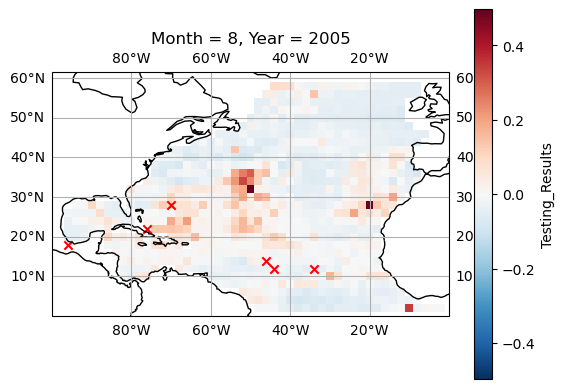

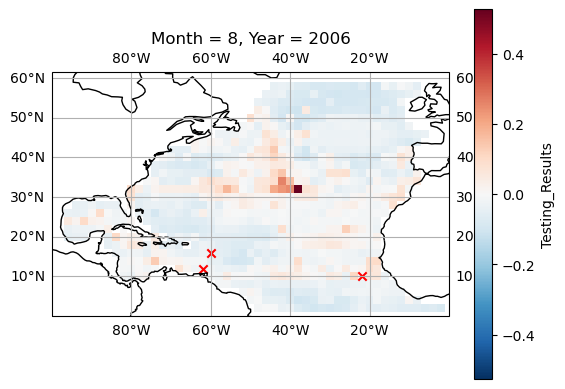

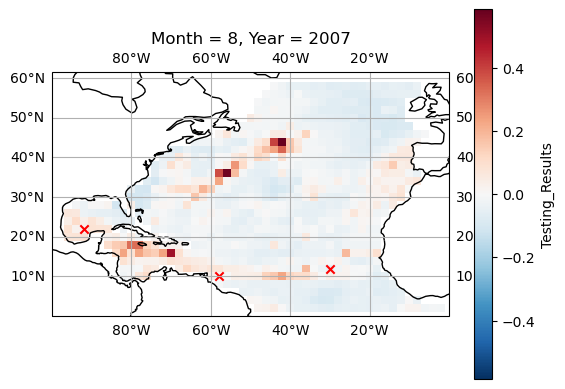

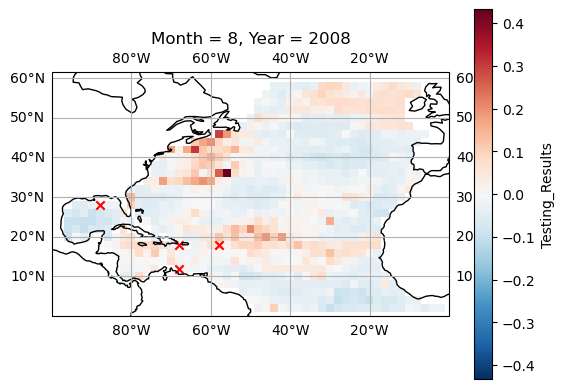

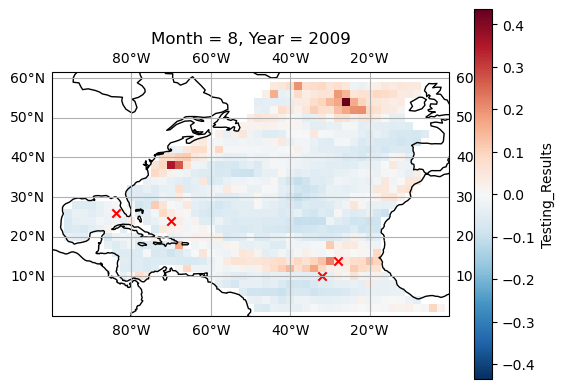

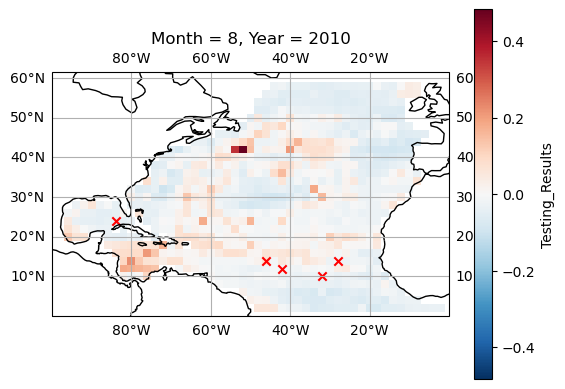

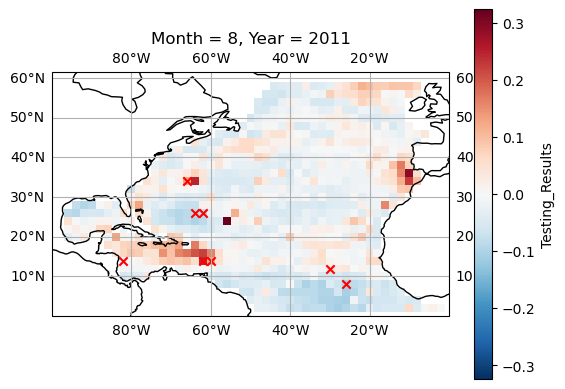

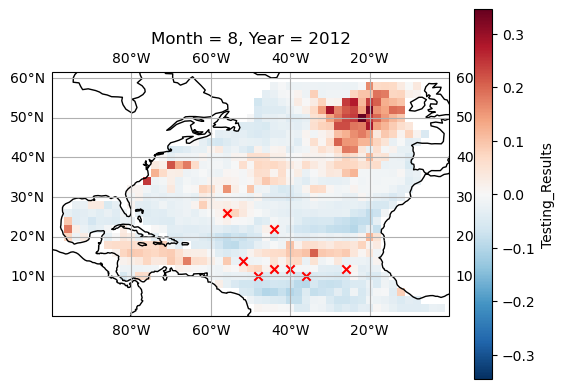

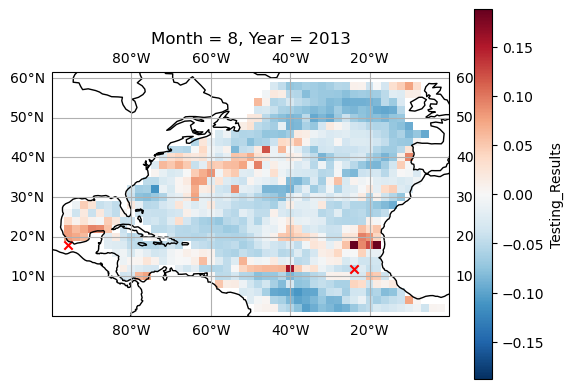

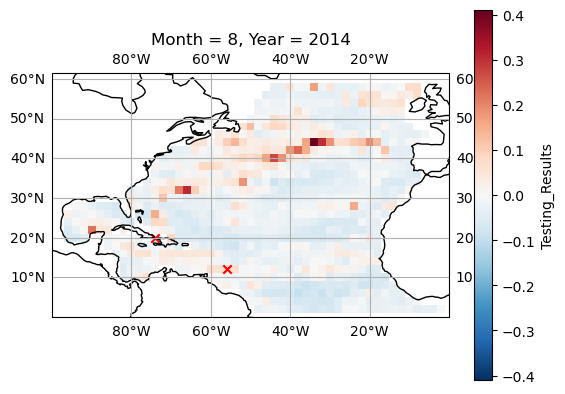

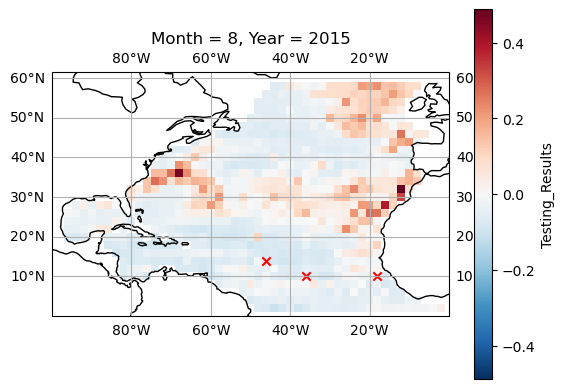

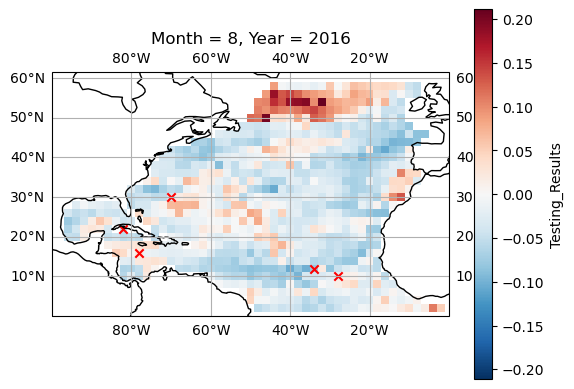

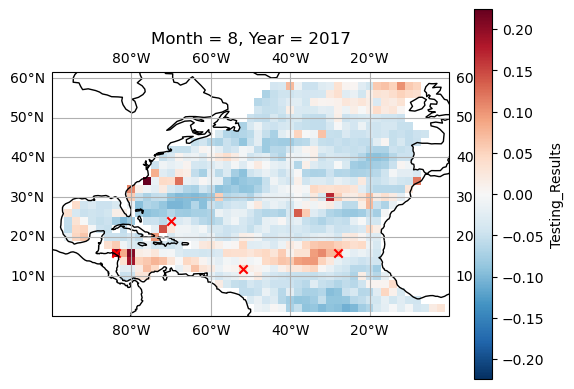

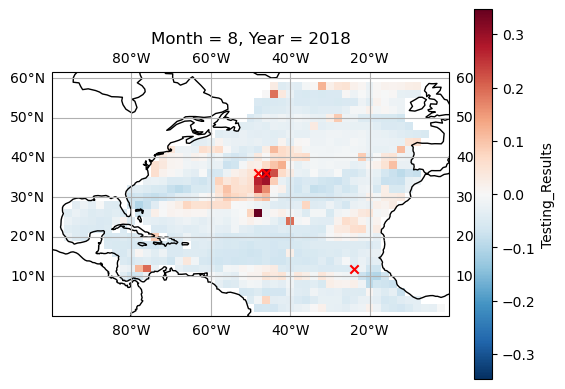

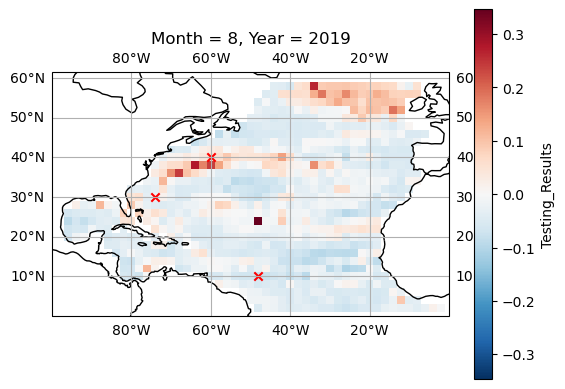

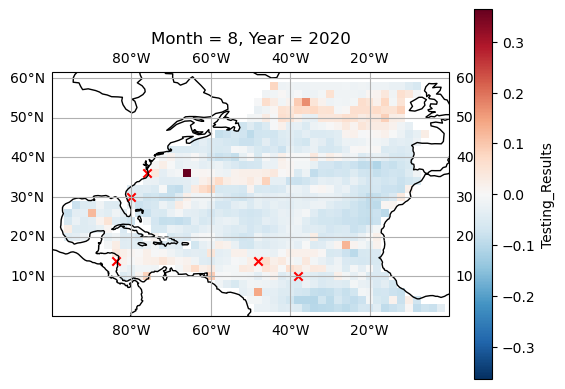

In [76]:
# Plot data
for test_years_now in test_years:
    mo_view = 8
    yr_view = test_years_now
    plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-100, 0, 0, 50])
    (test_ML_Predict_XR.unstack().sel(Month=mo_view,Year=yr_view)).plot()

    scat = test_labels_predropped_read.sel(Month=mo_view,Year=yr_view).stack(new=['Latitude','Longitude'])
    scat_dropped = scat.where(scat>0,drop=True)
    ax.scatter(scat_dropped['Longitude'],scat_dropped['Latitude'],marker='x',color='r')
    if mo_view > 9:
        mostr = str(mo_view)
    else:
        mostr = '0'+str(mo_view)
    timestr = mostr + '_' + str(yr_view)
    plt.show()
    #plt.savefig('/glade/work/acheung/RF_V2_Plots/RF_Reg_plot'+'_'+timestr+'.png',dpi=300)

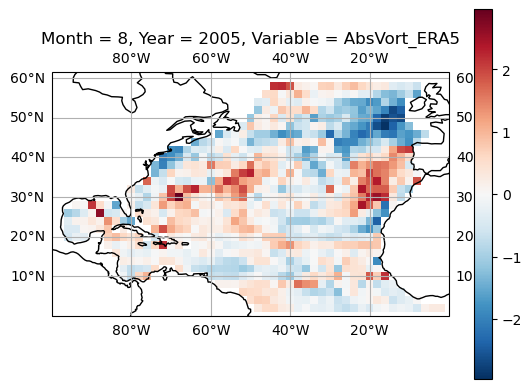

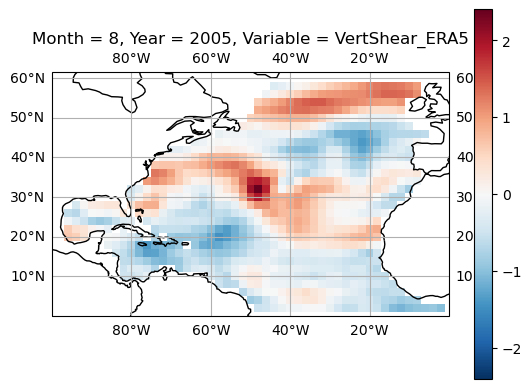

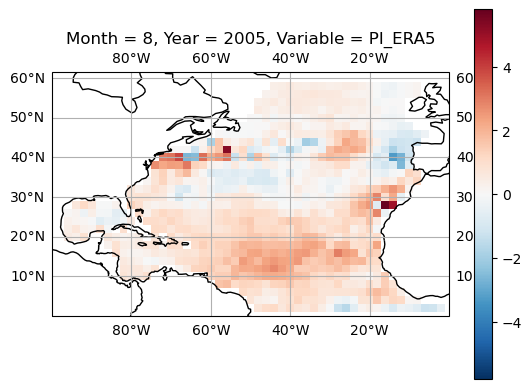

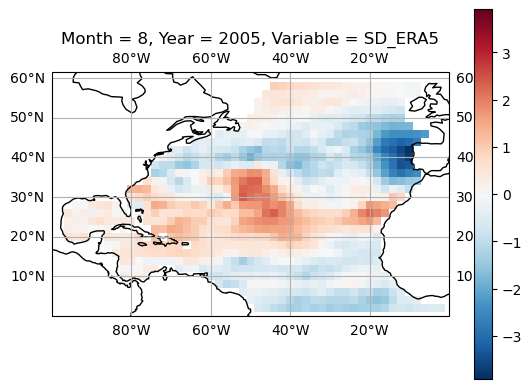

In [77]:
for i in range(4):
    # Plot Environmental Data
    plt.figure()
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    ax.set_extent([-100, 0, 0, 50])
    test_env_data.transpose('z','Variable')[:,i].unstack().sel(Month=8,Year=2005).plot()
    #plt.savefig("Anomaly_Normalized_Plot")
    plt.show()